<a href="https://colab.research.google.com/github/RajBharti25/ILD/blob/master/RISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/

/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir


In [0]:
import os
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import cm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms

In [4]:
resnet = models.resnet50(pretrained=True)
# Freeze model weights
for param in resnet.parameters():
    param.requires_grad = False

#adding new layers with 4 classes 
num_ftrs=resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 4)
#Lets Define training parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#loading the saved models parameter
# Model class must be defined somewhere
PATH='resnet_weight.pt'
model = torch.load(PATH)
model.eval()
print('model weight loaded')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



model weight loaded


In [0]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data.sampler import Sampler
from torchvision import transforms, datasets
from PIL import Image


# Dummy class to store arguments
class Dummy():
    pass


# Function that opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0)
])


# Plots image from tensor
def tensor_imshow(inp, title=None, **kwargs):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Mean and std for ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)


# Given label number returns class name
def get_class_name(c):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    return ' '.join(labels[c].split(',')[0].split()[1:])


# Image preprocessing function
preprocess = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                # Normalization for ImageNet
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])


# Sampler for pytorch loader. Given range r loader will only
# return dataset[r] instead of whole dataset.
class RangeSampler(Sampler):
    def __init__(self, r):
        self.r = r

    def __iter__(self):
        return iter(self.r)

    def __len__(self):
        return len(self.r)


In [0]:
import numpy as np
import torch
import torch.nn as nn
from skimage.transform import resize
from tqdm import tqdm


class RISE(nn.Module):
    def __init__(self, model, input_size, gpu_batch=100):
        super(RISE, self).__init__()
        self.model = model
        self.input_size = input_size
        self.gpu_batch = gpu_batch

    def generate_masks(self, N, s, p1, savepath='masks.npy'):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            # Random shifts
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            # Linear upsampling and cropping
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        np.save(savepath, self.masks)
        self.masks = torch.from_numpy(self.masks).float()
        #self.masks = self.masks.cuda()
        self.N = N
        self.p1 = p1

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float()
        self.N = self.masks.shape[0]
        self.p1 = 0.1


    def forward(self, x):
        N = self.N
        _, _, H, W = x.size()
        # Apply array of filters to the image
        stack = torch.mul(self.masks, x.data)

        # p = nn.Softmax(dim=1)(model(stack)) processed in batches
        p = []
        for i in range(0, N, self.gpu_batch):
            p.append(self.model(stack[i:min(i + self.gpu_batch, N)]))
        p = torch.cat(p)
        # Number of classes
        CL = p.size(1)
        sal = torch.matmul(p.data.transpose(0, 1), self.masks.view(N, H * W))
        sal = sal.view((CL, H, W))
        sal = sal / N / self.p1
        return sal

In [0]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models


In [0]:
args = Dummy()

# Number of workers to load data
args.workers = 8
# Directory with images split into class folders.
# Since we don't use ground truth labels for saliency all images can be 
# moved to one class folder.
args.datadir = '/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/'
# Sets the range of images to be explained for dataloader.
args.range = range(95, 105)
# Size of imput images.
args.input_size = (224, 224)
# Size of batches for GPU. 
# Use maximum number that the GPU allows.


In [9]:
resnet = models.resnet50(pretrained=True)
# Freeze model weights
for param in resnet.parameters():
    param.requires_grad = False
#adding new layers with 4 classes 
num_ftrs=resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 4)
#loading the saved models parameter
# Model class must be defined somewhere
PATH='resnet_weight1.pt'
model = torch.load(PATH)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
print('model weight loaded')

model weight loaded


In [0]:
explainer = RISE(model, args.input_size)

In [11]:
# Generate masks for RISE or use the saved ones.
maskspath = 'masks.npy'
generate_new = False
if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=1000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Masks are loaded.


In [0]:
b=(['pulmonary_fibrosis', 'hypersensitivity_pneumonitis', 'sarcoidosis','healthy'])
label_map={}
label_map_inverse={}
for l, x in enumerate(b):
  label_map_inverse[l]=x
  label_map[x]=l
root_dir='/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/'
img_name=['0.jpg','67.jpg','1104.jpg','881.jpg']
dir1=root_dir+img_name[0]
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/test_label.csv')
df=df[df.iloc[:,0]==img_name[0]]
idx=df.iloc[0,2]

In [0]:
def example(img, top_k=3):
    saliency = explainer(img)
    p, c = torch.topk(model(img), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k].item(), label_map_inverse[c[k].item()]))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(label_map_inverse[c[k].item()])
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

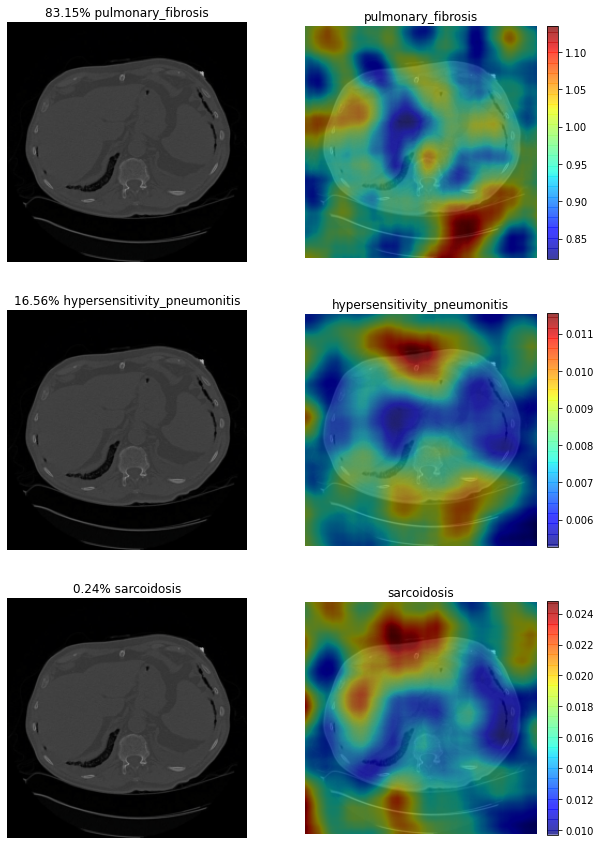

In [29]:
example(read_tensor(dir1), 3)

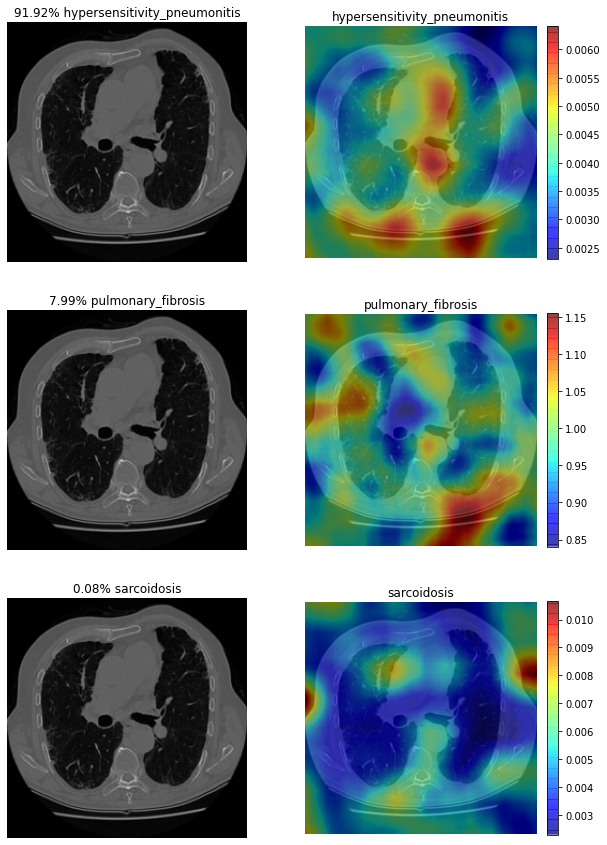

In [30]:
dir1=root_dir+img_name[1]
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/test_label.csv')
df=df[df.iloc[:,0]==img_name[1]]
idx=df.iloc[0,2]
example(read_tensor(dir1), 3)

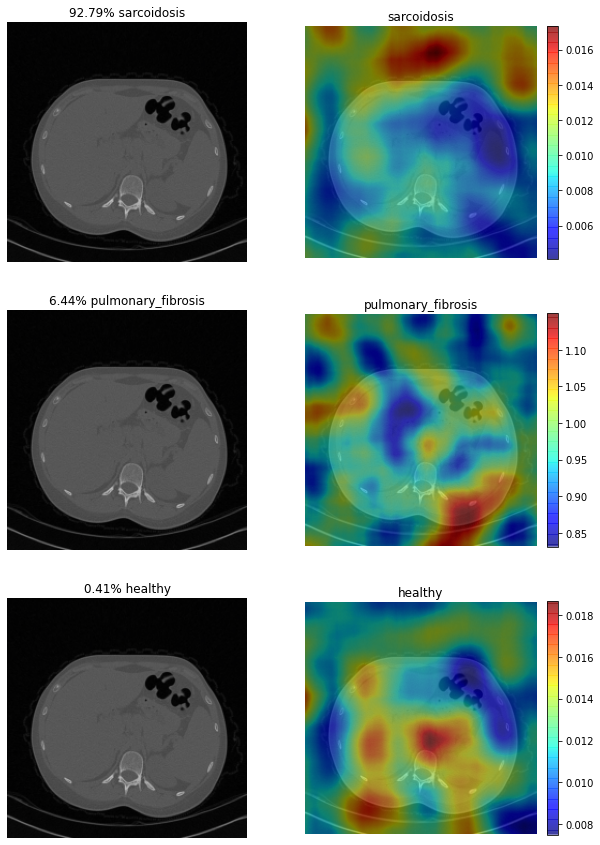

In [31]:
dir1=root_dir+img_name[2]
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/test_label.csv')
df=df[df.iloc[:,0]==img_name[2]]
idx=df.iloc[0,2]
example(read_tensor(dir1), 3)

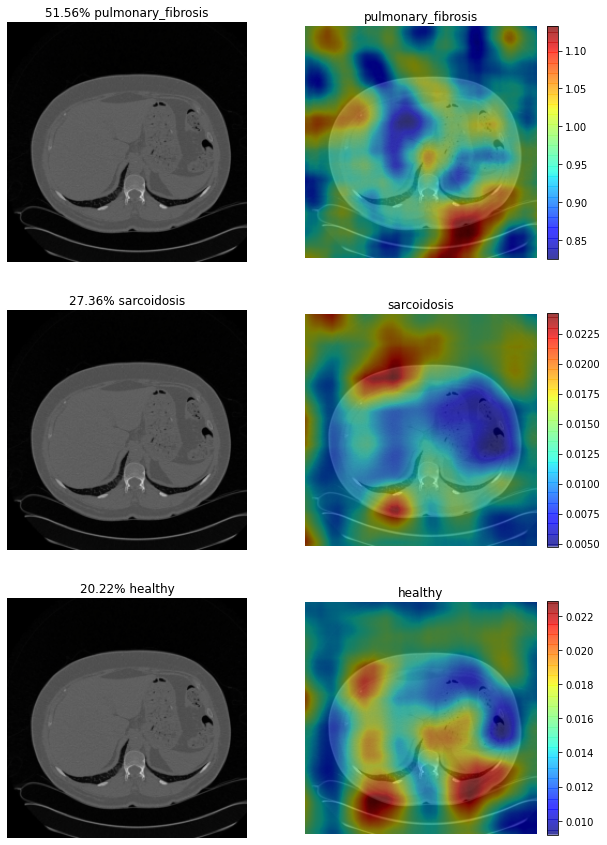

In [32]:
dir1=root_dir+img_name[3]
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/test_label.csv')
df=df[df.iloc[:,0]==img_name[3]]
idx=df.iloc[0,2]
example(read_tensor(dir1), 3)